In [0]:
# if using with google collab
# !git clone https://github.com/janchk/ML_HOMEWORK3
from ML_HOMEWORK3.nn import criterions, layers, optim, sequential
from ML_HOMEWORK3.data import data_proc
#else
# from nn import criterions, layers, optim, sequential
# from data import data_proc

In [0]:
from time import time, sleep
from IPython import display
import numpy as np
import matplotlib.pyplot as plt

### Toy example

#### Generating toy data

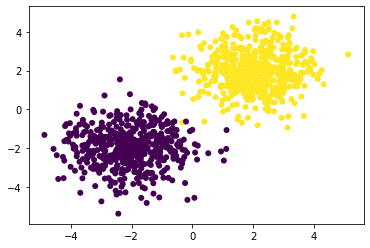

In [4]:
# Generate some data
N = 500

X1 = np.random.randn(N,2) + np.array([2,2])
X2 = np.random.randn(N,2) + np.array([-2,-2])

Y = np.concatenate([np.ones(N),np.zeros(N)])[:,None]
Y = np.hstack([Y, 1-Y])

X = np.vstack([X1,X2])
plt.scatter(X[:,0],X[:,1], c=Y[:,0], edgecolors='none')


#### Defining toy_net



In [5]:
toy_net = sequential.Sequential()
toy_net.add(layers.Linear(2, 40))
toy_net.add(layers.ReLU())
# toy_net.add(layers.Dropout(0.5))
toy_net.add(layers.GaussianDropout(0.5))
toy_net.add(layers.Linear(40, 10))
toy_net.add(layers.Sigmoid())
toy_net.add(layers.Linear(10, 2))
toy_net.add(layers.SoftMax())

criterion = criterions.MSECriterion()

print(toy_net)

[Linear 2 -> 40]
[ReLU]
[Gaussian Dropout]
[Linear 40 -> 10]
[Sigmoid]
[Linear 10 -> 2]
[SoftMax]



### Digit Classification

In [0]:
import os
from sklearn.datasets import fetch_openml

# Fetch MNIST dataset and create a local copy.
if os.path.exists('mnist.npz'):
    with np.load('mnist.npz', 'r', allow_pickle=True) as data:
        X = data['X']
        y = data['y']
else:
    mnist = fetch_openml("mnist_784")
    X, y = mnist.data / 255.0, mnist.target
    np.savez('mnist.npz', X=X, y=y)


One-hot encoding

In [7]:
from sklearn.preprocessing import OneHotEncoder

# num_digits = 10
encoder = OneHotEncoder() 
y_one_hot = encoder.fit_transform(y.reshape(-1, 1)).toarray()

print(X.shape)
print(y_one_hot.shape)

(70000, 784)
(70000, 10)


In [8]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, test_size=0.33, random_state=42, shuffle=True)
print(np.shape(X_train))
print(np.shape(y_test))

(46900, 784)
(23100, 10)


In [0]:
def train (net, optimizer_config, batch_size, num_epochs, X_train, y_train, X_test, y_test):
    optimizer_state = {}
    avg_loss = []
    avg_train_acccuracy = []
    test_accuracy = []
    test_losses = []
    for i in range(num_epochs):
        loss_history = []
        accuracy_history = []
        for x_batch, y_batch in data_proc.get_batches((X_train, y_train), batch_size):
            net.train()
            net.zeroGradParameters()
            
            # Forward
            predictions = net.forward(x_batch)
            loss = criterion.forward(predictions, y_batch)
        
            # Backward
            dp = criterion.backward(predictions, y_batch)
            net.backward(x_batch, dp)
            
            # Update weights
            optim.sgd_momentum(net.getParameters(), 
                         net.getGradParameters(), 
                         optimizer_config,
                         optimizer_state)      
            
            loss_history.append(loss)
            bin_pred = [np.where(pred==np.max(pred), 1, 0) for pred in predictions]
            accuracy = accuracy_score(y_batch, bin_pred) 
            accuracy_history.append(accuracy)
        
        avg_loss.append(sum(loss_history) / len(loss_history))
        avg_train_acccuracy.append(sum(accuracy_history) / len(accuracy_history))
        test_acc, test_loss = eval(net, X_test, y_test)
        test_accuracy.append(test_acc)
        test_losses.append(test_loss)
        
        # Visualize
        display.clear_output(wait=True)
        plt.figure(figsize=(16, 8))

        plt.subplot(1, 2, 1)            
        plt.title("Loss")
        plt.xlabel("epoch")
        plt.plot(avg_loss, 'b', label="avg_loss")
        plt.plot(test_losses, 'r', label="test_loss")
        plt.legend()
        # plt.show()
        
        plt.subplot(1, 2, 2)
        plt.title("Accuracy")
        plt.xlabel("epoch")
        plt.plot(avg_train_acccuracy, 'b', label="avg_train_accuracy")
        plt.plot(test_accuracy, 'r', label="test_accuracy")
        plt.legend()
        plt.show()
        
        print('epoch : %i' %i)
        print('Current epoch train loss: %f' % avg_loss[i])
        print('Current epoch test loss: %f' % test_losses[i])
        print('Current epoch train accuracy: %f' % avg_train_acccuracy[i])
        print('Current epoch test accuracy: %f' % test_accuracy[i])
    print("\nThe net architecture is:\n")    
    print(net)
    
def eval(net, X_data, y_data):
    net.evaluate()
    y_pred = net.forward(X_data)
    y_pred_bin = [np.where(pred==np.max(pred), 1, 0) for pred in y_pred] 
    accuracy = accuracy_score(y_data, y_pred_bin)
    loss = criterion.forward(y_pred, y_data)
    return accuracy, loss

### Define zoo

In [0]:
# The simpliest variant. 
mnist_net_1 = sequential.Sequential()

mnist_net_1.add(layers.Linear(784, 10))
mnist_net_1.add(layers.SoftMax())


# 2 layers and activation
mnist_net_2 = sequential.Sequential()

mnist_net_2.add(layers.Linear(784, 300))
mnist_net_2.add(layers.ReLU())
mnist_net_2.add(layers.Linear(300, 10))
mnist_net_2.add(layers.SoftMax())

# 2 layers with dropout
mnist_net_2_drop = sequential.Sequential()

mnist_net_2_drop.add(layers.Linear(784, 300))
mnist_net_2_drop.add(layers.ReLU())
mnist_net_2_drop.add(layers.Dropout())
mnist_net_2_drop.add(layers.Linear(300, 10))
mnist_net_2_drop.add(layers.SoftMax())

mnist_net_3 = sequential.Sequential()

mnist_net_3.add(layers.Linear(784, 300))
mnist_net_3.add(layers.ReLU())
mnist_net_3.add(layers.Dropout())
mnist_net_3.add(layers.Linear(300, 100))
mnist_net_3.add(layers.ReLU())
mnist_net_3.add(layers.Dropout())
mnist_net_3.add(layers.Linear(100, 10))
mnist_net_3.add(layers.SoftMax())

mnist_net_3_gaussian = sequential.Sequential()

mnist_net_3_gaussian.add(layers.Linear(784, 300))
mnist_net_3_gaussian.add(layers.ReLU())
mnist_net_3_gaussian.add(layers.GaussianDropout())
mnist_net_3_gaussian.add(layers.Linear(300, 100))
mnist_net_3_gaussian.add(layers.ReLU())
mnist_net_3_gaussian.add(layers.GaussianDropout())
mnist_net_3_gaussian.add(layers.Linear(100, 10))
mnist_net_3_gaussian.add(layers.SoftMax())

Training zoo

In [0]:
# Optimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
# optimizer_state = {}

# Looping params
n_epoch = 40
batch_size = 512


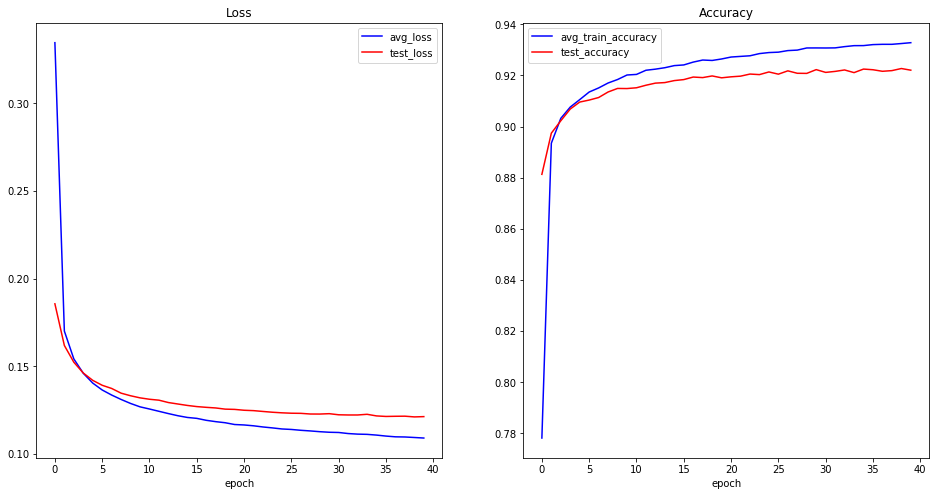

epoch : 39
Current epoch train loss: 0.109142
Current epoch test loss: 0.121352
Current epoch train accuracy: 0.932831
Current epoch test accuracy: 0.922078

The net architecture is:

[Linear 784 -> 10]
[SoftMax]



In [12]:
train(mnist_net_1, optimizer_config, batch_size, n_epoch, X_train, y_train, X_test, y_test)


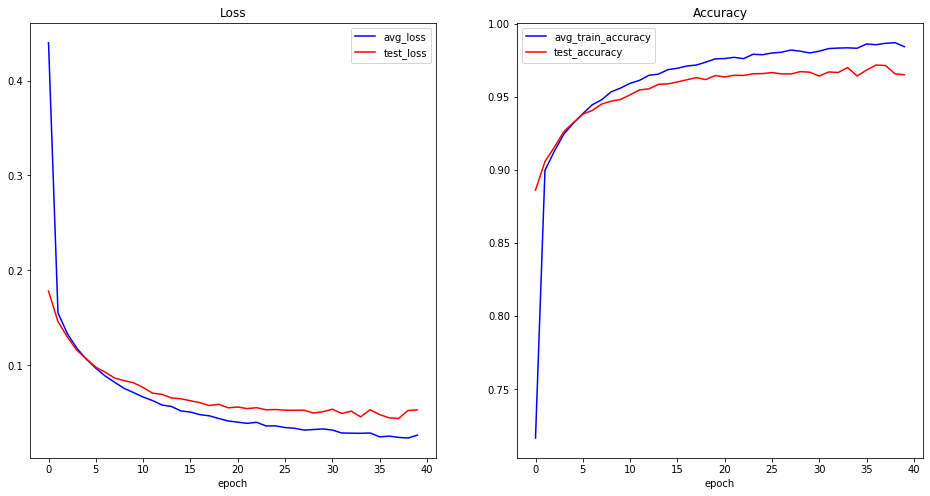

epoch : 39
Current epoch train loss: 0.026555
Current epoch test loss: 0.053164
Current epoch train accuracy: 0.984382
Current epoch test accuracy: 0.965152

The net architecture is:

[Linear 784 -> 300]
[ReLU]
[Linear 300 -> 10]
[SoftMax]



In [13]:
train(mnist_net_2, optimizer_config, batch_size, n_epoch, X_train, y_train, X_test, y_test)


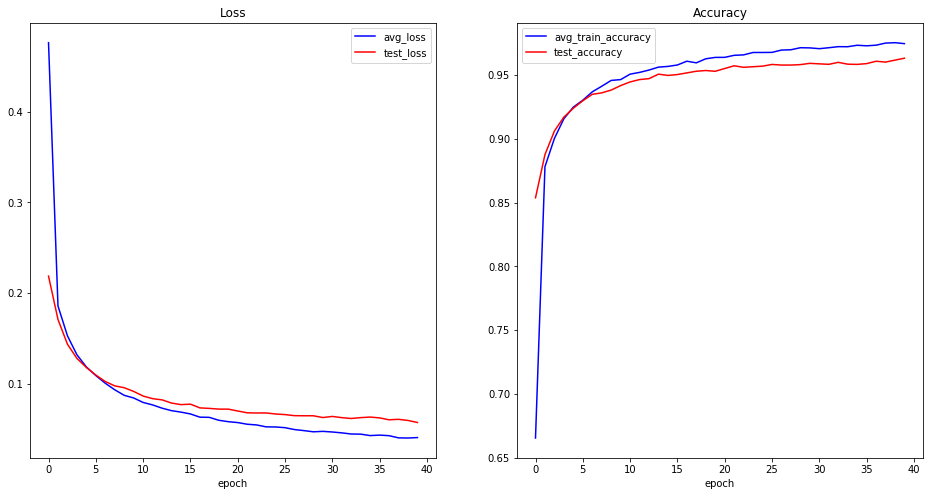

epoch : 39
Current epoch train loss: 0.040850
Current epoch test loss: 0.057464
Current epoch train accuracy: 0.974639
Current epoch test accuracy: 0.963203

The net architecture is:

[Linear 784 -> 300]
[ReLU]
[Dropout]
[Linear 300 -> 10]
[SoftMax]



In [14]:
train(mnist_net_2_drop, optimizer_config, batch_size, n_epoch, X_train, y_train, X_test, y_test)

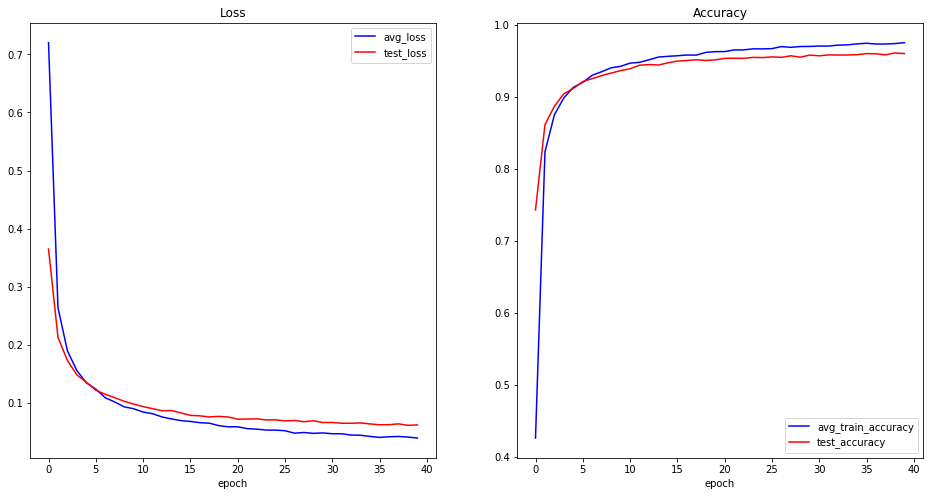

epoch : 39
Current epoch train loss: 0.039430
Current epoch test loss: 0.062042
Current epoch train accuracy: 0.975247
Current epoch test accuracy: 0.960043

The net architecture is:

[Linear 784 -> 300]
[ReLU]
[Dropout]
[Linear 300 -> 100]
[ReLU]
[Dropout]
[Linear 100 -> 10]
[SoftMax]



In [15]:
train(mnist_net_3, optimizer_config, batch_size, n_epoch, X_train, y_train, X_test, y_test)

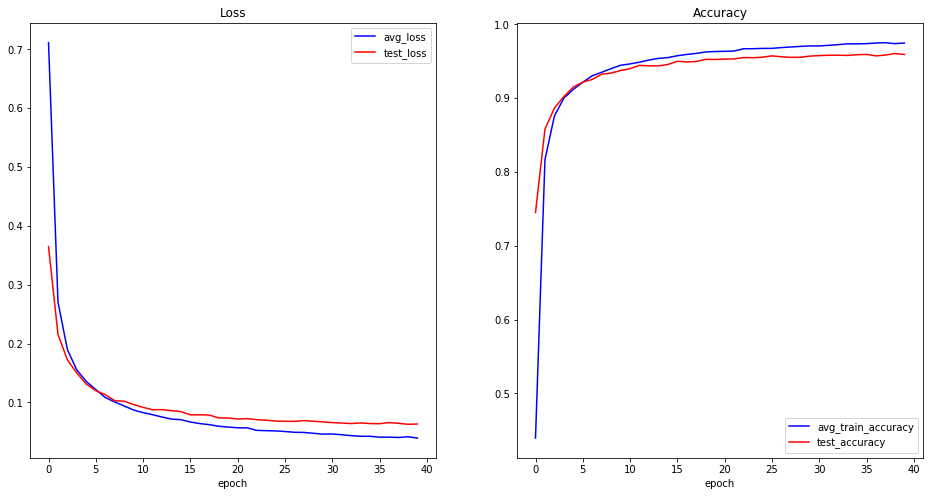

epoch : 39
Current epoch train loss: 0.039322
Current epoch test loss: 0.063159
Current epoch train accuracy: 0.974865
Current epoch test accuracy: 0.959221

The net architecture is:

[Linear 784 -> 300]
[ReLU]
[Gaussian Dropout]
[Linear 300 -> 100]
[ReLU]
[Gaussian Dropout]
[Linear 100 -> 10]
[SoftMax]



In [16]:

train(mnist_net_3_gaussian, optimizer_config, batch_size, n_epoch, X_train, y_train, X_test, y_test)

MD
